In [1]:
## Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import plotly.graph_objects as go
import plotly.subplots as sp
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
from pulp import LpProblem, LpVariable, LpMinimize, lpSum, LpStatus
import matplotlib.pyplot as plt
import numpy as np
import time 
import os
import seaborn as sns
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

# Read Data

In [2]:
# read input data
INPUT_PATH = 'D:/MpEnsystems/SE4ALL DF 2024/DF model/input files for model/input data/'

OUTPUT_PATH = 'D:/MpEnsystems/SE4ALL DF 2024/DF model/input files for model/output/'


ppa =pd.read_excel(INPUT_PATH + 'MODCON.xlsx') # PPA data of thermal plants (Capacity, ramping limts, technical min, variable cost)
projected_demand = pd.read_csv(INPUT_PATH + 'demand8760.csv') # Discom hourly demand in MW 
market_price = pd.read_excel(INPUT_PATH+'market_rate8760.xlsx') # Power market RTM prices for last year
re = pd.read_excel(INPUT_PATH +'RE8760.xlsx') #RE genration forecast
tariff = pd.read_csv(INPUT_PATH +'tariff_10.csv') # cluster wise hourly tariff
mode=['DF','DF','DF','DF','DF','DR','DR','DR','DR','DF'] # cluster wise demnand flexibility mode (Demand felxibility, demand response, demand response 2)
flex = [0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5] # cluster wise % flexibility
# flex = [0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1]

# RE forecast module

AN- based timeseries forecasting module - Creates weather forecast for GHI, wind Speed, temperature specific to geographical locations and estimates the solar and wind energy generation forecaste for desired time period

In [ ]:
# Solar Power Forecasting Using LSTM





set_seed(455)
np.random.seed(455)

dataset = pd.read_csv("C:/Users\Kaustubh\Downloads\GHI_Daily.csv",parse_dates=["Date"]).drop([],axis=1)

dataset = dataset.sort_values(by='Date')
dataset = dataset.set_index("Date")
print(dataset.head())
print(dataset.describe()) 
dataset.isna().sum()       

tstart = 2001
tend = 2022
def train_test_plot1(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "Temperature"].plot(figsize=(16,4), legend=True)
    dataset.loc[f"{tend+1}":, "Temperature"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("Temperature (°C)")
    plt.show()
train_test_plot1(dataset,tstart,tend)

def train_test_plot2(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "GHI"].plot(figsize=(16,4), legend=True)
    dataset.loc[f"{tend+1}":, "GHI"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("Radiation (kWh/m2/day)")
    plt.show()
train_test_plot2(dataset,tstart,tend)

def train_test_split1(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "Temperature"].values
    test = dataset.loc[f"{tend+1}":, "Temperature"].values
    return train, test
training_set1, test_set1 = train_test_split1(dataset, tstart, tend)

def train_test_split2(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "GHI"].values
    test = dataset.loc[f"{tend+1}":, "GHI"].values
    return train, test
training_set2, test_set2 = train_test_split2(dataset, tstart, tend)

sc1 = MinMaxScaler(feature_range=(0, 1))
training_set1 = training_set1.reshape(-1, 1)
training_set1_scaled = sc1.fit_transform(training_set1)
sc2 = MinMaxScaler(feature_range=(0, 1))
training_set2 = training_set2.reshape(-1, 1)
training_set2_scaled = sc2.fit_transform(training_set2)

def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

n_steps = 30       
features = 1       
epochs_n = 50

X_train1, y_train1 = split_sequence(training_set1_scaled, n_steps)
X_train2, y_train2 = split_sequence(training_set2_scaled, n_steps)
X_train1 = X_train1.reshape(X_train1.shape[0],X_train1.shape[1],features)
X_train2 = X_train2.reshape(X_train2.shape[0],X_train2.shape[1],features)

model_lstm1 = Sequential()   # To create a linear stack of layers for the model
model_lstm1.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))
model_lstm1.add(Dense(units=1))
model_lstm1.compile(optimizer="RMSprop", loss="mse")
model_lstm1.summary()
model_lstm1.fit(X_train1, y_train1, epochs=epochs_n, batch_size=32)

model_lstm2 = Sequential()  
model_lstm2.add(LSTM(units=125, activation="tanh", input_shape=(n_steps, features)))
model_lstm2.add(Dense(units=1))
model_lstm2.compile(optimizer="RMSprop", loss="mse")
model_lstm2.summary()
model_lstm2.fit(X_train2, y_train2, epochs=epochs_n, batch_size=32)

dataset_total1 = dataset.loc[:,"Temperature"]
inputs1 = dataset_total1[len(dataset_total1) - len(test_set1) - n_steps :].values
inputs1 = inputs1.reshape(-1, 1)
inputs1 = sc1.transform(inputs1)
X_test1, y_test1 = split_sequence(inputs1, n_steps)
X_test1 = X_test1.reshape(X_test1.shape[0], X_test1.shape[1], features)
predicted_Temperature_d = model_lstm1.predict(X_test1)
predicted_Temperature_d = sc1.inverse_transform(predicted_Temperature_d)
predicted_Temperature_d = pd.DataFrame(predicted_Temperature_d)

dataset_total2 = dataset.loc[:,"GHI"]
inputs2 = dataset_total2[len(dataset_total2) - len(test_set2) - n_steps :].values
inputs2 = inputs2.reshape(-1, 1)
inputs2 = sc2.transform(inputs2)
X_test2, y_test2 = split_sequence(inputs2, n_steps)
X_test2 = X_test2.reshape(X_test2.shape[0], X_test2.shape[1], features)
predicted_GHI_d = model_lstm2.predict(X_test2)
predicted_GHI_d = sc2.inverse_transform(predicted_GHI_d)
predicted_GHI_d = pd.DataFrame(predicted_GHI_d)

def return_rmse1(test1, predicted1):
    rmse1 = np.sqrt(mean_squared_error(test1, predicted1))
    print("The root mean squared error in temperature is {:.2f}%.".format(rmse1))

def return_rmse2(test2, predicted2):
    rmse2 = np.sqrt(mean_squared_error(test2, predicted2))
    print("The root mean squared error in GHI is {:.2f}%.".format(rmse2))
    
return_rmse1(test_set1,predicted_Temperature_d)
return_rmse2(test_set2,predicted_GHI_d)

# -------------- GHI-POA conversion (Transposition factor) --------------------

from pvlib import location
from pvlib import irradiance
import pytz
import itertools

tz = pytz.timezone("Asia/Kolkata")
lat, lon = 19.166960663858482, 72.95055406717977
site = location.Location(lat, lon, tz=tz)

def get_irradiance(site_location,date, tilt, surface_azimuth):
    times = pd.date_range(date, freq='10min', periods=6*24,
                          tz=site_location.tz)
    clearsky = site_location.get_clearsky(times)
    solar_position = site_location.get_solarposition(times=times)
    POA_irradiance = irradiance.get_total_irradiance(
        surface_tilt=tilt,
        surface_azimuth=surface_azimuth,
        dni=clearsky['dni'],
        ghi=clearsky['ghi'],
        dhi=clearsky['dhi'],
        solar_zenith=solar_position['apparent_zenith'],
        solar_azimuth=solar_position['azimuth'])
    return pd.DataFrame({'GHI': clearsky['ghi'],
                         'POA': POA_irradiance['poa_global']})

dates = pd.Series(pd.date_range(str(2023) + "-01-01", str(2023) + "-12-31", freq="D"))
dates = dates.to_frame(name='Timestamp')
dates['Timestamp'] = dates['Timestamp'].dt.strftime('%d/%m/%Y')

Final_irr = pd.DataFrame()
for i in range(365):
    Total_irr = get_irradiance(site,dates.iloc[i-1,0], 20, 0)
    Total_irr = Total_irr.reset_index(drop=True)
    Final_irr = pd.concat([Final_irr,Total_irr],axis=1)

Temp_irradiance = get_irradiance(site,dates.iloc[0,0], 20, 0)
Final_irr.index = Temp_irradiance.index.strftime("%H:%M:%S")
Final_irr = Final_irr.transpose()
GHI = Final_irr[0::2] 
POA = Final_irr[1::2] 
GHI = GHI.reset_index(drop=True)
POA = POA.reset_index(drop=True)
TF_10min = POA/GHI
TF_10min = TF_10min.set_index(dates.iloc[:,0]) 

TF_hr = pd.DataFrame()
for x in range(0,144,6):
    TF_hr0 = (TF_10min.iloc[:, x:x+5].mean(axis=1))
    TF_hr0 = TF_hr0.to_frame()
    TF_hr = pd.concat([TF_hr,TF_hr0],axis=1)

myRange = np.arange(00,24,1)
df0 = (pd.DataFrame({"numbers": myRange})).transpose()
TF_hr.columns = df0.columns 

TF_d = TF_hr.mean(axis=1) 
TF_d = TF_d.to_frame()

# xxxxxxxxxxxxxxxxxx Transposition Factor End xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx

predicted_GHI_d.index = TF_d.index
predicted_Temperature_d.index = TF_d.index
estimated_POA_d = TF_d * predicted_GHI_d
estimated_POA_avg = (estimated_POA_d*1000*3600)/(10*3600)

# ---------------------------- Power calculations -----------------------------
# From Datasheet
Pnom = 16             # rated power output of the PV module under standard test conditions [kW]
nDRT = 95/100         # PV derating factor [%] (soiling, wiring losses, shading, snow cover, aging etc.)
alpha = -0.35/100     # temperature coefficient of power [%/°C]
gamma = 0.02          # determined by the mounting type of the system
A_PV = 1              # surface area of the PV module [m2]
Tc_NOCT = 45          # nominal operating cell temperature [°C]
Ta_NOCT = 20          # ambient temperature at which the NOCT is defined [20°C]

Tc_STC = 25          # cell temperature under standard test conditions [25°C]
GT_STC = 1           # the radiation at standard test conditions [1 kW/m2]
GT = estimated_POA_d  # solar radiation striking the PV array [kW/m2]
GT_NOCT = 0.8         # solar radiation at which the NOCT is defined [0.8 kW/m2]
Ta = predicted_Temperature_d # ambient temperature [°C]
Tau_alpha = 0.9       # product of the solar absorptance and the solar transmittance is 0.9 or 90%

nmp_STC = Pnom / (A_PV*GT_STC) / 100 # efficiency of the PV module under standard test conditions [%]

U0 = 29     # constant heat transfer component (W/m2K) (Free-standing:29, Semi integrated with airduct behind: 20, Fully insulated back: 15)
U1 = 0      # convective heat transfer component (W/m3sK) (Wind loss factor is 0 for all )
WS = 1      # Typical wind speed (m/s)
Tc = Ta + estimated_POA_avg * ((Tau_alpha*(1-nmp_STC))/(U0 + WS*U1))
Pdc = Pnom*nDRT*(GT/GT_STC)*(1+alpha*(Tc-Tc_STC))
spGen = Pdc/Pnom
PR = (spGen/estimated_POA_d)*100
PR = PR.map("{:,.2f}%".format)

Pdc = Pdc.rename(columns={0: "DC Power (kW)"})
spGen = spGen.rename(columns={0: "spGen (kWh/kWp/day)"}) 
PR = PR.rename(columns={0: "PR (%)"})

test_set1 = pd.DataFrame(test_set1, columns =['Temperature'])
test_set2 = pd.DataFrame(test_set2, columns =['GHI'])
test_set1.index = predicted_Temperature_d.index
test_set2.index = predicted_GHI_d.index
def plot_temperature(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("Temperature (°C) Prediction")
    plt.xlabel("Day")
    plt.ylabel("Temperature (°C)")
    plt.legend()
    plt.show()
    
def plot_radiation(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("Radiation (GHI) Prediction")
    plt.xlabel("Day")
    plt.ylabel("Radiation (GHI)")
    plt.legend()
    plt.show()
    
def plot_power(test):
    plt.plot(test, color="green")
    plt.title("Total DC Power Per Day Estimation")
    plt.xlabel("Day")
    plt.ylabel("DC Power (kW)")
    plt.legend()
    plt.show()
    
def plot_spGen(test):
    plt.plot(test, color="red")
    plt.title("Avg Daily spGen Estimation")
    plt.xlabel("Day")
    plt.ylabel("spGen (kWh/kWp/day)")
    plt.legend()
    plt.show()    

def plot_PR(test):
    plt.plot(test, color="blue")
    plt.title("Avg PR Estimation")
    plt.xlabel("Day")
    plt.ylabel("PR (%)")
    plt.legend()
    plt.show()

plot_temperature(test_set1,predicted_Temperature_d)
plot_radiation(test_set2,predicted_GHI_d)
plot_power(Pdc)
plot_spGen(spGen)
plot_PR(PR)

# Clustering of load profile data


k-means algorithm - creates load patterns from smart meter consumer level data

In [3]:
def load_profile_clustering(tariff):
    start_time_cl = time.time()
    cwd = os.path.abspath('D:/MpEnsystems/SE4ALL DF 2024/DF model/input files for model/input data/meter data/') 
    files = os.listdir(cwd) 
    print(files)

    clusters_rqd = [3,3,4,3,3,3,3,3]
    ci=-1
    final_clusters = pd.DataFrame()
    for file in files:
        ci=ci+1
        if file.endswith('.csv'):
            print(f"Processing file: {file}") 
            file_path = os.path.join(cwd, file) 
            data1 = pd.read_csv(file_path)
    
            data_load = data1.drop(columns ='slots')        
            max_load = data_load.max()
            norm_mvd = data_load/max_load
            number_of_meters = len(data_load.columns)
#             clusters_rqd = int(input("Please enter no. of clusters required for " + str(file).strip('.csv') + " category:"))
            cluster_centroids = pd.DataFrame(index=range(len(norm_mvd)),columns = range(clusters_rqd[ci]))        
            cluster_centroids = norm_mvd.iloc[:,[random.randint(1, number_of_meters-1) for _ in range(clusters_rqd[ci])]]
            
            #meter list
            meter_list_1 = norm_mvd.columns.tolist()
            #cost matrix
            cost_matrix = pd.DataFrame(index = range(len(cluster_centroids.columns)), columns = meter_list_1)
            
            #iterative clustering
            number_of_iterations = 15 
            
            for it in range(number_of_iterations):
                for i in range(number_of_meters):
                
                    for n in range(len(cluster_centroids.columns)):
                        cost_matrix.iloc[n,i] = sum(norm_mvd.iloc[:,i] - cluster_centroids.iloc[:,n])**2
                
                    min_value_indices = np.argmin(np.array(cost_matrix), axis=0)
            
                for nn in range(len(cluster_centroids.columns)): 
                    indexes = np.where(min_value_indices == nn)[0]
                    if it == number_of_iterations-1:
                        cluster_centroids.iloc[:,nn] = data_load.iloc[:,indexes].mean(axis=1)
                    else:
                        cluster_centroids.iloc[:,nn] = norm_mvd.iloc[:,indexes].mean(axis=1)  
                      
            
            clustered_meters_list = pd.DataFrame(index = range(1),columns = ['C' + str(i) for i in range(1, clusters_rqd[ci]+1)])
            for ii in range (len(cluster_centroids.columns)):
                indexes = np.where(min_value_indices == ii)[0]
                clustered_meters_list.iloc[0,ii] = indexes  
            
            # cluster_centroids.columns = [str(file).strip('.csv') +'_Cluster-' + str(i) for i in range(1, clusters_rqd+1)]
            cluster_centroids.columns = [(str(file))[:3] +'_Cluster-' + str(i) for i in range(1, clusters_rqd[ci]+1)]
            categorywise_cluster = cluster_centroids.to_dict()
            final_clusters = pd.concat([final_clusters,cluster_centroids],axis=1)
            
            
    aggregate_demand_from_clusters = final_clusters.sum(axis=1)
    
    tariff_df = pd.DataFrame(columns=final_clusters.columns, index = range(len(final_clusters)))
    tariff_df.iloc[:,:] = tariff.iloc[:,:]
    bills = final_clusters.iloc[:,:]*tariff_df.iloc[:,:]
    
            
    end_time_cl = time.time()
            
    print('Total time elapsed: ', end_time_cl -start_time_cl)
    return final_clusters, aggregate_demand_from_clusters,bills,indexes
    

# Trigger calculation for DR and DF


Creates triggers for each cluster based on slotwise per unit generation cost
For DR - triggers are generated for slots with pu generation cost is more than the threshold value
For DF - triggers are generated for slots with pu generation cost higher than upper limit or lower than lower limit
Triggers are created in a way to shift the demand from slots with higher pu generation cost to slots with lower generation cost

In [4]:
def trigger_calculation2(pu_gen_cost, tariff, mode, n):
    
    # pricing signal calculation based on monthly variation in slot wise per unit generation cost
    
    pu_gen_cost_daily = pd.DataFrame(columns=range(365), index=range(24))
    monthly_avg = pd.DataFrame(columns=range(12), index=range(24))

    for d in range(len(pu_gen_cost_daily.columns)):
        pu_gen_cost_daily.iloc[:, d] = pu_gen_cost[d*24:(d+1)*24]

    for m in range(len(monthly_avg.columns)):
        monthly_avg.iloc[:, m] = pu_gen_cost_daily.iloc[:, m*30:(m+1)*30].mean(axis=1)

    triggers = pd.DataFrame(index=range(len(pu_gen_cost)), columns=tariff.columns)
    DF_trigger = pd.DataFrame(index=range(len(pu_gen_cost)), columns=['trigger(INR/kWH)', 'month'])
    DR_incentive = pd.DataFrame(index=range(len(pu_gen_cost)), columns=['trigger(INR/kWH)', 'month'])

    for m in range(len(monthly_avg.columns)):
        DF_trigger.iloc[m*30*24:30*24*(m+1), 1] = m
        DR_incentive.iloc[m*30*24:30*24*(m+1), 1] = m    

    DF_trigger.iloc[12*30*24:, 1] = 11
    DR_incentive.iloc[12*30*24:, 1] = 11

    DR_lambda = 0.3
    DF_lambda = 0.3
    
    DF_m = pd.DataFrame(np.zeros((24, 12)), columns=range(12))
    DR_m = pd.DataFrame(np.zeros((24, 12)), columns=range(12))
    
    for m in range(12):
        gencdc = monthly_avg.iloc[:, m].sort_values().reset_index()
        monthly_gen_avg = gencdc.iloc[:, 1]
        mean_cost_ub = monthly_gen_avg[20]
        mean_cost_lb = monthly_gen_avg[3]
        threshold = monthly_gen_avg[20]

        for s in range(24):
            if monthly_avg.iloc[s, m] > mean_cost_ub:
                DF_m.iloc[s, m] = -mean_cost_ub + monthly_avg.iloc[s, m]
            elif monthly_avg.iloc[s, m] < mean_cost_lb:
                DF_m.iloc[s, m] = -mean_cost_lb + monthly_avg.iloc[s, m]
            if monthly_avg.iloc[s, m] >= threshold:
                DR_m.iloc[s, m] = -threshold + monthly_avg.iloc[s, m]

    for d in range(365):
        try:
            month_index = int(DF_trigger.iloc[d*24, 1])
            DF_trigger.iloc[d*24:(d+1)*24, 0] = DF_m.iloc[:, month_index]
            DR_incentive.iloc[d*24:(d+1)*24, 0] = DR_m.iloc[:, month_index]
        except Exception as e:
            logging.error(f"Error processing day {d}: {e}")

    for i in range(len(tariff.columns)):
        if mode[i] == 'DR':
            triggers.iloc[:, i] = DR_incentive.iloc[:, 0] * (DR_lambda + n*0.1) + tariff.iloc[:, i]
        elif mode[i] == 'DF':
            triggers.iloc[:, i] = tariff.iloc[:, i] + DF_trigger.iloc[:, 0] * (DF_lambda + n*0.1)
        else:
            triggers.iloc[:, i] = DR_incentive.iloc[:, 0] * (1 + n*0.1)

    return triggers



In [5]:
def trigger_calculation(pu_gen_cost, tariff, mode, n=1):
    
    # pricing signal calculation based on monthly variation in slot wise per unit generation cost levels
    number_of_trigger_levels = 3
    pu_gen_cost_daily = pd.DataFrame(columns=range(365), index=range(24))
    monthly_avg = pd.DataFrame(columns=range(12), index=range(24))

    for d in range(len(pu_gen_cost_daily.columns)):
        pu_gen_cost_daily.iloc[:, d] = pu_gen_cost[d*24:(d+1)*24]

    for m in range(len(monthly_avg.columns)):
        monthly_avg.iloc[:, m] = pu_gen_cost_daily.iloc[:, m*30:(m+1)*30].mean(axis=1)

    triggers = pd.DataFrame(index=range(len(pu_gen_cost)), columns=tariff.columns)
    DF_trigger = pd.DataFrame(index=range(len(pu_gen_cost)), columns=['trigger(INR/kWH)', 'month'])
    DR_incentive = pd.DataFrame(index=range(len(pu_gen_cost)), columns=['trigger(INR/kWH)', 'month'])

    for m in range(len(monthly_avg.columns)):
        DF_trigger.iloc[m*30*24:30*24*(m+1), 1] = m
        DR_incentive.iloc[m*30*24:30*24*(m+1), 1] = m    

    DF_trigger.iloc[12*30*24:, 1] = 11
    DR_incentive.iloc[12*30*24:, 1] = 11

    DR_lambda = 0.3
    DF_lambda = 0.3
    
    DF_m = pd.DataFrame(np.zeros((24, 12)), columns=range(12))
    DR_m = pd.DataFrame(np.zeros((24, 12)), columns=range(12))
    
    for m in range(12):
        gencdc = monthly_avg.iloc[:, m].sort_values().reset_index()
        monthly_gen_avg = gencdc.iloc[:, 1]
        mean_genc = monthly_gen_avg.mean()
        step_size = ((monthly_gen_avg - mean_genc).max() -(monthly_gen_avg - mean_genc).min())/number_of_trigger_levels
    

        for s in range(24):
            if monthly_avg.iloc[s, m] >= mean_genc*1.05:
                DF_m.iloc[s, m] = round((monthly_avg.iloc[s,m] - mean_genc)/step_size)
            elif monthly_avg.iloc[s, m] < mean_genc*0.95:
                DF_m.iloc[s, m] = round((monthly_avg.iloc[s,m] - mean_genc)/step_size)
                
            if monthly_avg.iloc[s, m] >= mean_genc*1.05:
                DR_m.iloc[s, m] = round((monthly_avg.iloc[s,m] - mean_genc)/step_size)

    for d in range(365):
        try:
            month_index = int(DF_trigger.iloc[d*24, 1])
            DF_trigger.iloc[d*24:(d+1)*24, 0] = DF_m.iloc[:, month_index]
            DR_incentive.iloc[d*24:(d+1)*24, 0] = DR_m.iloc[:, month_index]
        except Exception as e:
            logging.error(f"Error processing day {d}: {e}")

    for i in range(len(tariff.columns)):
        if mode[i] == 'DR':
            triggers.iloc[:, i] = DR_incentive.iloc[:, 0] * (DR_lambda + n*0.1) + tariff.iloc[:, i]
        elif mode[i] == 'DF':
            triggers.iloc[:, i] = tariff.iloc[:, i] + DF_trigger.iloc[:, 0] * (DF_lambda + n*0.1)
        else:
            triggers.iloc[:, i] = DR_incentive.iloc[:, 0] * (1 + n*0.1)

    return triggers



In [7]:
def trigger_calculation1(pu_gen_cost, tariff,mode,n):
    
    # pricing signal calculation based on slot wise per unit generation cost

    gencdc = pu_gen_cost.sort_values().reset_index()
    gen_cost_dc = gencdc.iloc[:,1]
    mean_cost_ub = gen_cost_dc[int(len(gen_cost_dc)*0.96)] # top 0.5 % slots with higher pu_gen_cost
    mean_cost_lb = gen_cost_dc[int(len(gen_cost_dc)*0.03)] # bottom 0.5 % slots with higher pu_gen_cost
    
    triggers = pd.DataFrame(index = range(len(pu_gen_cost)), columns = tariff.columns)
    DF_trigger =np.zeros(len(pu_gen_cost)) 
    DR_incentive =np.zeros(len(pu_gen_cost)) 
    
    pu_cost_gap = pu_gen_cost.max() - pu_gen_cost.mean()
#     mean_cost_lb = pu_gen_cost.mean()*0.6
#     mean_cost_ub = pu_gen_cost.mean()*1.35
    
    DR_lambda = 0.5
    DF_lambda = 0.5
    
  
    
    threshold = gen_cost_dc[int(len(gen_cost_dc)*0.97)]
    
    print('Upper bound pu_gen_cost:', mean_cost_ub)
    print('Lower bound pu_gen_cost:', mean_cost_lb)
    
#     print(pu_gen_cost.mean(),mean_cost_lb,mean_cost_ub,threshold,pu_gen_cost.max())
    
    for s in range(len(pu_gen_cost)):
        if pu_gen_cost[s]>=mean_cost_ub:
            DF_trigger [s] = 1
        elif pu_gen_cost[s]<mean_cost_lb: 
            DF_trigger[s] = -1
        else:
            DF_trigger[s] =0
                
        if pu_gen_cost[s] >=threshold:
            DR_incentive[s] = 1
    
#     plt.plot(DR_incentive*DR_lambda)
    for i in range(len(tariff.columns)):
        if mode[i]=='DR':
            triggers.iloc[:,i] =  DR_incentive[:]*(DR_lambda +n*0.1) + tariff.iloc[:,i]
        elif mode[i] =='DF':
            triggers.iloc[:,i] = tariff.iloc[:,i] + DF_trigger*(DF_lambda+n*0.1)
        else:
            triggers.iloc[:,i] = DR_incentive[:]*(1+n*0.1)
                
            
    return triggers
            

# Consumer load optimisation

Optimises the cluster level load profiles based on triggers, DF/DR program and flexibility to minimise the consumer bills

Objective: Minimise (consumer bill + inconvenience to consumers) / maximise (DR incentive -inconvenience to consumers)

Constraints: 
1. DF program - Daily total energy use must not change from BAU
2. DR program - % limits on reduction in daily total energy 
3. % Flexibility - range within which the load shape can be modulated


In [8]:
def load_optimisation_aggregate(cluster_triggers,mode,flexibility,clustered_profile):
    total_slots = len(tariff)
    daily_slots = 24
    # print(clustered_profile.iloc[:,:])

    num_columns = len(clustered_profile.columns)
    opt_clusters = [f'Cluster_{i+1}' for i in range(num_columns)]

    optimized_clusters = pd.DataFrame(columns = opt_clusters, index = range(len(clustered_profile)))
    start = time.time()
    for c in range(num_columns):
        cluster_profile = clustered_profile.iloc[:,c].reset_index(drop=True)
        tariff_structure =cluster_triggers.iloc[:,c].reset_index(drop=True)
        opt_profile = load_optimisation(tariff_structure, cluster_profile, flex[c],mode[c])
        optimized_clusters.iloc[:,c] = opt_profile[0]  

                 
    end = time.time()
    
    tff = cluster_triggers
    tff.columns = optimized_clusters.columns
    
    bills = 1000*optimized_clusters.mul(tff)
    
    return optimized_clusters, bills

In [9]:
def load_optimisation(triggers, clustered_profile, flexibility, mode):
    
    num_hours = len(clustered_profile)
    daily_slots = 24
    num_days = int(num_hours/daily_slots)
    inconvineance_cost = 1 # 0.5 INR/kWH change in daily demand

    if mode == 'DF':
        Bill_optimization = LpProblem("Bill_optimization", LpMinimize)
   
        shifted_load = [LpVariable(f"{t}_shifted_load", lowBound=clustered_profile[t]*(1-flexibility),upBound = clustered_profile[t]*(1+flexibility)) for t in range(num_hours)]

        total_shift = [LpVariable(f"{t}_total_shift") for t in range(num_hours)]        
   
      # Constraint 1 Total energy consumption is same for the day
        for d in range(num_days):
            Bill_optimization += lpSum(shifted_load[t+d*daily_slots] for t in range(daily_slots)) == clustered_profile[d*daily_slots:(d+1)*daily_slots].sum()
    
      # Constraint 2 total shifted energy for calculating inconvinence
        for t in range(num_hours):
                   Bill_optimization += total_shift[t]>=clustered_profile[t] - shifted_load[t]
                   Bill_optimization += total_shift[t]>=-clustered_profile[t] + shifted_load[t]
       
        
#      # inconvinience to consumer  
        incovinience = lpSum(total_shift[t]*inconvineance_cost for t in range(num_hours))
    
        #Objective fucntcion (minimise the bill i.e. electricity cost to consumers + inconvinence)
        Bill_optimization += lpSum(shifted_load[t] * triggers[t] for t in range(num_hours)) +incovinience                         
        
        
        Bill_optimization.solve()

    
        opt_load = pd.DataFrame(index=range(len(shifted_load)), columns=range(1))
        
    elif mode == 'DR':
    
        Bill_optimization = LpProblem("Bill_optimization", LpMinimize)
      
        shifted_load = [LpVariable(f"{t}_shifted_load", lowBound=clustered_profile[t]*(1-flexibility),upBound = clustered_profile[t]) for t in range(num_hours)]
        total_shift = lpSum(clustered_profile[t] -shifted_load[t] for t in range(num_hours))

      # Objective fucntcion (minimise the bill i.e. electricity cost to consumers + inconvinence)
        Bill_optimization += lpSum(shifted_load[t] *triggers[t] for t in range(num_hours)) +total_shift*inconvineance_cost
   
  
      # Constraint 1 Total energy reduction limitted to 5 % of total baseline consumption
        for d in range(num_days):
            Bill_optimization += lpSum(shifted_load[t+d*daily_slots] for t in range(daily_slots)) >= (1-0.05)*clustered_profile[d*daily_slots:(d+1)*daily_slots].sum()
    
        Bill_optimization.solve()

        opt_load = pd.DataFrame(index=range(len(shifted_load)), columns=range(1))
        
    else:
            
        Bill_optimization = LpProblem("Bill_optimization", LpMinimize)
    
        shifted_load = [LpVariable(f"{t}_shifted_load", lowBound=clustered_profile[t]*(1-flexibility),upBound = clustered_profile[t]) for t in range(num_hours)]
        total_shift = lpSum(clustered_profile[t] -shifted_load[t] for t in range(num_hours))
        
        # Objective fucntcion (minimise the bill i.e. electricity cost to consumers + inconvinence)
    
        Bill_optimization += lpSum(-shifted_load[t] * triggers[t] for t in range(num_hours))+ total_shift*inconvineance_cost
     
        # Constraint 1 Total energy reduction limitted to 5 % of total baseline consumption
  
        for d in range(num_days):
            Bill_optimization += lpSum(shifted_load[t+d*daily_slots] for t in range(daily_slots)) >= (1-0.05)*clustered_profile[d*daily_slots:(d+1)*daily_slots].sum() 
    
        Bill_optimization.solve()
    
        opt_load = pd.DataFrame(index=range(len(shifted_load)), columns=range(1))
        
    
    print("Demand optimisation Status:", LpStatus[Bill_optimization.status]) 

    for i in range(len(shifted_load)):
        opt_load.iloc[i,0]=shifted_load[i].varValue
        
    return opt_load

# Generation cost optimisation - Security constrained economic dispatch 

Disptach model for scheduling conventional generators for net load requirment

Objective: Minimise generation cost

Constraints: 
1. technical minimum of generators
2. supply - demand balance
3. ramping limits for generators
4. limits on individual generation capacity
4. limits on power purchased from IEX - optional
5. battery energy storage system - limits on energy and power capacities

In [10]:
def compute_generation_cost(demand,n=0):    
    #RE Power generation profiles
    
    start_time = time.time()
   

    solar_pu_cost = 0
    wind_pu_cost =0
    market_limit = 0.00
    
    solar=re['Solar']
    wind=re['Wind']
    RE=solar+wind

    # Net demand for conventional genration
    net_demand = demand - re.sum(axis=1)

    num_plants=len(ppa['Capacity'])
   

    
    generation_capacity = ppa['Capacity']
    technical_minimum = ppa['Technical_min']
    fixed_cost = ppa['Fixed cost']  # Fixed cost for each plant
    Variable_cost=ppa['Variable cost']
   
    battery_power_capacity = 100
    battery_energy_capacity =0
    battery_initial_state = 0 # initial state of charge

    total_daily_energy = projected_demand.iloc[:,:].sum()
    cost_matrix = pd.DataFrame()

    ramping_up = ppa['Ramping_up'] # Ramping up limit for each plant
    ramping_down = ppa['Ramping down']  # Ramping down limit for each plant
    

    num_plants=len(generation_capacity)
    num_hours=len(demand.values)
#     print(num_hours)
  
# --------------------------------------------------------------------------------

    problem = LpProblem("Power_Generation_Optimization", LpMinimize)

    # Define the decision variables
    schedule = [[LpVariable(f"Schedule_{t}_{p}") for p in range(num_plants)] 
                for t in range(num_hours)]
    market_drawl = [LpVariable(f"Market_{t}") for t in range(num_hours)]
    b_soc = [LpVariable(f"b_soc_{t}",lowBound=0, upBound = battery_energy_capacity) for t in range(num_hours+1)]
               
    

    # Set the objective function
    problem += lpSum(schedule[t][p] * Variable_cost[p] for t in range(num_hours) for p in range(num_plants))+lpSum(market_drawl[t]*market_price['rate'][t] for t in range(num_hours))
   

    # Add the constraints

    #Constraint 1  - ramping up and down constraints 1% for thermal, 3% for gas, 10% for hydro
    for t in range(num_hours - 1):
        for p in range(num_plants):
            del_schedule = schedule[t+1][p] - schedule[t][p]
            problem += ramping_down[p] <= del_schedule <= ramping_up[p]

    #Constraint 2 -  technical Minimum
    for t in range(num_hours):
        for p in range(num_plants):
            problem += schedule[t][p]>=technical_minimum[p]


    #Constraint 3 - Total generation in slot i = Total demand in slot i
    for t in range(num_hours):
        problem += lpSum(schedule[t][p] for p in range(num_plants)) ==net_demand[t]-market_drawl[t]-b_soc[t]+b_soc[t+1]
        

    #Constraint 4 - Generation should not exceed capacity
    for t in range(num_hours):
        for p in range(num_plants):
            problem += schedule[t][p] <= ppa['Capacity'][p]
            
     #constraint 5 - sales in market power should be less thanmarket limit of net demand
    for t in range(num_hours):
        problem +=market_drawl[t] <=market_limit*net_demand[t]
        problem +=market_drawl[t] >=-market_limit*net_demand[t]
        
#     #constraint 7 - battery charging and discharging constriants

    for t in range(num_hours):
        b_power = b_soc[t]-b_soc[t+1]
        problem+= -battery_power_capacity<=b_power<=battery_power_capacity
    
           
    # Solve the problem
    problem.solve()

    # Check the status of the solution
    
    print("Generation optimisation Status:", LpStatus[problem.status])  

    end_time0=time.time()
 #______________________________________________________________________________________________________   
    # saving variable values in dataframe

    schedule_gen = pd.DataFrame(index=range(num_hours), columns=range(num_plants))
    market_power = pd.DataFrame(index=range(num_hours))
    battery_profile = pd.DataFrame(index=range(num_hours))
    
   
    for t in range(num_hours):
        for p in range(num_plants):
            schedule_gen.at[t, p] = schedule[t][p].varValue
        market_power.at[t,0] = market_drawl[t].varValue
        battery_profile.at[t,0]=b_soc[t+1].varValue
        
       
    # dataframe to csv
    schedule_gen.to_csv(OUTPUT_PATH + "schedule_output_" + str(n) + ".csv", index=False)
    
    # generation cost = schedule of plant * variable_cost
    re_cost = solar*solar_pu_cost + wind*wind_pu_cost
    market_cost = market_power.iloc[:,0]*market_price.iloc[:,0]
    total_generation_cost = np.dot(np.array(schedule_gen.iloc[:,:]),np.array(Variable_cost[:])) + re_cost +market_cost
#     cost_without_RE = total_generation_cost - re_cost
    
    #per unit generation cost = total generation cost /total units
    per_unit_generation_cost = total_generation_cost/(projected_demand['demand'] - re.sum(axis=1))
    
    end_time= time.time()
    
    total_time1 = end_time0 - start_time
    total_time2 = end_time - start_time
#     print('Time taken for optimisation:',total_time1)
    print('Total time elapsed:',total_time2)

    return per_unit_generation_cost, market_power, battery_profile

# Algorithm based on hierarchical decision making

Model approach: Hierarchical decision making algorithm is designed to model interaction between utility and consumer for demand flexibility and demand response programs. 

Step 1. Utility calculates the generation cost estimates for the time period in consideration and identities the time periods with high generation cost and low generation cost.

Step 2: Utility creates pricing signals/triggers for consumers to achieve demand modulation

Step 3: Consumer data is analysed based on pricing signals/triggers and optimised consumer load profiles are calculated

Step 4: Utility calculates the demand considering optimised consumer load profiles and estimates the generation cost.

Step 5: Utility calculates the net savings in generation cost after accommodating incentive cost occurred for demand modulation.

Step 6: Step 2 to Step 5 are repeated until the net savings in subsequent iterations are converged.

['hospital.csv', 'pww.csv', 'residential.csv']
Processing file: hospital.csv
Processing file: pww.csv
Processing file: residential.csv
Total time elapsed:  25.321494817733765


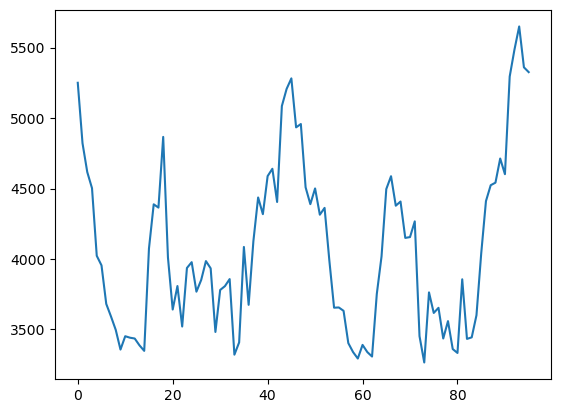

In [11]:
[consumer_load_clusters, aggregate_demand_from_clusters,cluster_bills,min_indexes] =load_profile_clustering(tariff)
consumer_load_clusters = 2000*consumer_load_clusters
aggregate_demand_from_clusters = consumer_load_clusters.sum(axis=1)
# # # # consumer_load_clusters = 0.5*consumer_load_clusters
# # # # aggregate_demand_from_clusters = 0.5*aggregate_demand_from_clusters
# # # # consumer_load_clusters.iloc[:,6] = consumer_load_clusters.iloc[:,7]
# # # # cluster_bills = 1000* cluster_bills
# print(consumer_load_clusters)
plt.plot(consumer_load_clusters[0:96].sum(axis = 1))

In [13]:
start_time = time.time()
# create dictionaries to store data in each iteration
iterative_tariff_signals ={}
iterative_demand ={}
iterative_pu_gen_cost = {}
iterative_opt_load = {}
iterative_cluster_bills = {}
iterative_market_power = {}
iterative_battery_dispatch ={}
iterative_total_gen_cost = {}

# initial conditions BAU without DF and DR

n= 0 
print('iteration: ',n)
iterative_tariff_signals[n] = tariff
iterative_demand[n]= projected_demand['demand']
print('Generation optimisation....')
[pu_gen_cost, market_power, battery_dispatch] = compute_generation_cost(iterative_demand[0])
iterative_pu_gen_cost[n] = pu_gen_cost
iterative_opt_load[n] = consumer_load_clusters
iterative_market_power[n]=market_power
iterative_battery_dispatch[n] = battery_dispatch
iterative_cluster_bills [n] = cluster_bills
iterative_total_gen_cost[n] = 1000*(iterative_pu_gen_cost[n]*iterative_demand[n]).sum()

fixed_demand = iterative_demand[0] - aggregate_demand_from_clusters
print('---------------------------------')
# Sequesntial process of determing incentive struture by DISCOM and DF/DR response from consumers
gen_cost_i = pu_gen_cost
number_of_iterations = 2
n=n+1
while n < number_of_iterations:
    print('iteration: ',n)
    # Incentive / tariff signal estimation
    
    print('calculating triggers....')
    cluster_triggers = trigger_calculation (gen_cost_i, tariff,mode,n)
    
    # Introduce flexibility
    print('Load curves optimisations....')
    optimised_cluster_loads, cluster_bills = load_optimisation_aggregate (cluster_triggers,mode,flex,consumer_load_clusters)
    aggregated_opt_cl_load = optimised_cluster_loads.sum(axis = 1)
    
    # calculate net_demand
    demand_i = fixed_demand + aggregated_opt_cl_load
    net_demand_i  = demand_i
    print('Generation optimisation....')
    # Comput updated gen cost 
    [pu_gen_cost_i, market_power_i, battery_dispatch_i] = compute_generation_cost(net_demand_i)
    
    gen_cost_i = pu_gen_cost_i
    
   
    iterative_tariff_signals[n] = cluster_triggers
    iterative_demand[n]= demand_i
    iterative_pu_gen_cost[n] = pu_gen_cost_i
    iterative_opt_load[n] = optimised_cluster_loads
    iterative_market_power[n] = market_power_i
    iterative_battery_dispatch[n] = battery_dispatch_i
    iterative_cluster_bills [n] = cluster_bills
    iterative_total_gen_cost[n] =1000*(iterative_pu_gen_cost[n]*iterative_demand[n]).sum()
     
    
    change_in_DF_consumer_bill = iterative_cluster_bills[n-1].sum() - iterative_cluster_bills[n].sum() # should be positive for consumer benefit
    change_in_profit_to_utility= (iterative_total_gen_cost[n-1] - iterative_total_gen_cost[n] - change_in_DF_consumer_bill.sum()) #should be positive for utility benefit
    print(0.05*iterative_total_gen_cost[n-1])
    print('---------------------------------')
    n=n+1
#     if change_in_profit_to_utility < 0.05*iterative_total_gen_cost[n-1]: break    
    
    
end_time = time.time()

print(end_time - start_time)

iteration:  0
Generation optimisation....
Generation optimisation Status: Optimal
Total time elapsed: 128.12337040901184
---------------------------------
iteration:  1
calculating triggers....
Load curves optimisations....
Demand optimisation Status: Optimal
Demand optimisation Status: Optimal
Demand optimisation Status: Optimal
Demand optimisation Status: Optimal
Demand optimisation Status: Optimal
Demand optimisation Status: Optimal
Demand optimisation Status: Optimal
Demand optimisation Status: Optimal
Demand optimisation Status: Optimal
Demand optimisation Status: Optimal
Generation optimisation....
Generation optimisation Status: Optimal
Total time elapsed: 117.73459529876709
23121332626.841568
---------------------------------
271.46203875541687


0.01247781386046361


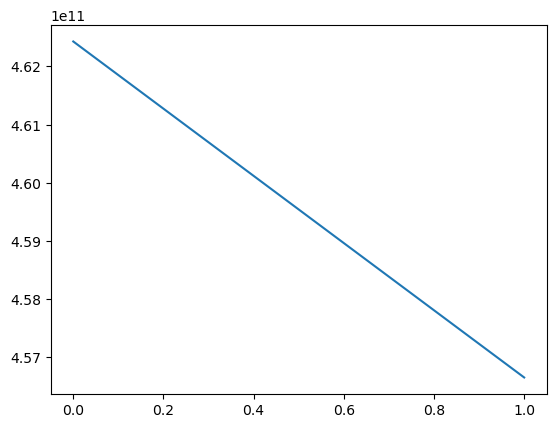

In [14]:
plt.plot(iterative_total_gen_cost.values())
print((iterative_total_gen_cost[0]-iterative_total_gen_cost[1])/iterative_total_gen_cost[0])

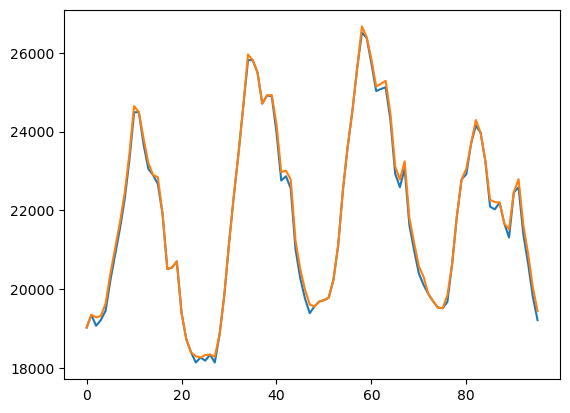

In [15]:
start_day = 1
iteration = 1
plt.plot(iterative_demand[iteration][(start_day-1)*24:(start_day-1)*24+96])
plt.plot(iterative_demand[0][(start_day-1)*24:(start_day-1)*24+96])
# plt.plot(projected_demand['demand'][(start_day-1)*24:(start_day-1)*24+96])

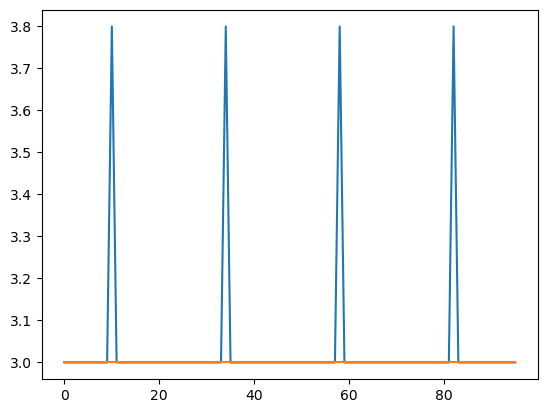

In [16]:
plt.plot(iterative_tariff_signals[iteration].iloc[(start_day-1)*24:(start_day-1)*24+96,5])
plt.plot(iterative_tariff_signals[0].iloc[(start_day-1)*24:(start_day-1)*24+96,0])

In [47]:
pu_gen_cost_daily = pd.DataFrame(columns=range(365), index = range(24))
   

for d in range(len(pu_gen_cost_daily.columns)):
    pu_gen_cost_daily.iloc[:,d] =  iterative_pu_gen_cost[3][d*24:(d+1)*24]
    

monthly_avg = pd.DataFrame(columns = range(12), index = range(24))
for m in range(len(monthly_avg.columns)):
    monthly_avg.iloc[:,m] = pu_gen_cost_daily.iloc[:,m*30:(m+1)*30].mean(axis = 1)

<Axes: >

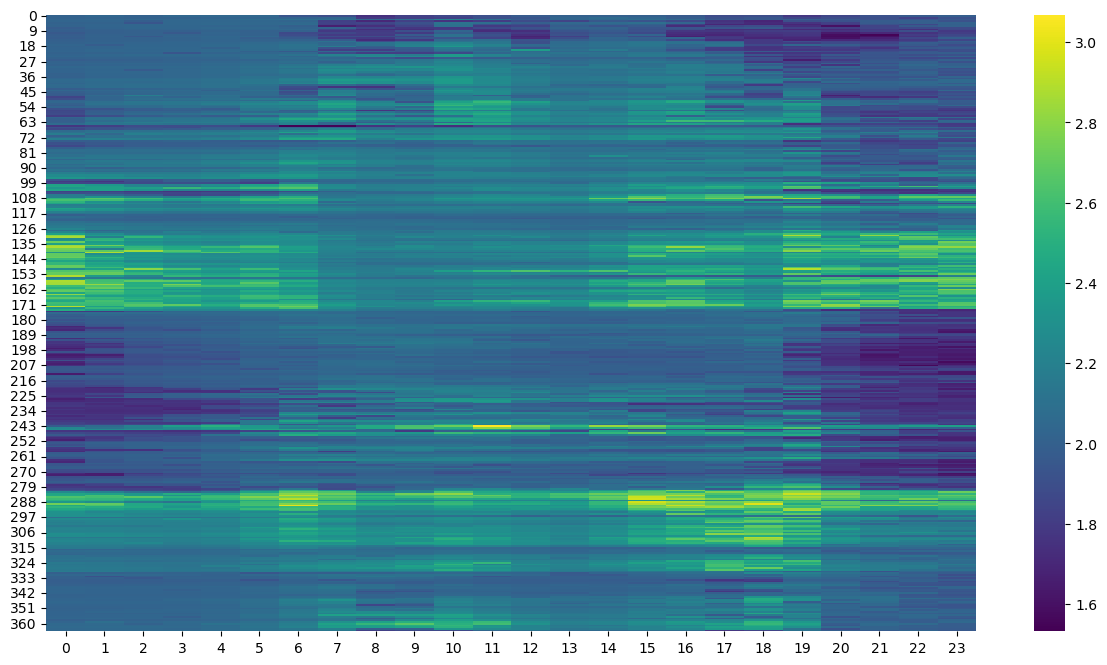

In [48]:
plt.figure(figsize=(15, 8)) 
sns.heatmap(pu_gen_cost_daily.T.astype(float), cmap='viridis', cbar=True)